In [15]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, asin, sqrt
from sknetwork.embedding import SVD
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_fscore_support

RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

In [16]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2 * asin(sqrt(a)) * 6371

def conformal_quantile(scores, alpha):
    n = len(scores)
    q = np.quantile(scores, np.ceil((n + 1) * (1 - alpha)) / n)
    return q

In [17]:
def load_graph_sparse(path):
    df = pd.read_csv(path, sep='\t', header=None, usecols=[0,1], names=['u', 'v'])
    
    rows = np.concatenate([df['u'].values, df['v'].values])
    cols = np.concatenate([df['v'].values, df['u'].values])
    data = np.ones(len(rows))
    
    n_nodes = max(rows.max(), cols.max()) + 1
    
    adj = sp.csr_matrix((data, (rows, cols)), shape=(n_nodes, n_nodes))
    
    adj.data = np.ones_like(adj.data)
    adj.setdiag(0)
    return adj

def load_positions(path):
    if not path: return None
    df = pd.read_csv(path, sep='\t', header=None)
    pos = {}
    for _, row in df.iterrows():
        pos[row.iloc[0]] = (row.iloc[-2], row.iloc[-1]) 
    return pos

print("Data loaders ready.")


Data loaders ready.


In [18]:
def get_node_features(adj):
    # Feature 1: Degrees
    degrees = np.array(adj.sum(axis=1)).flatten()
    
    # Feature 2: SVD Embeddings
    print("Computing SVD Embeddings (Rank 32)...")
    svd = SVD(n_components=32)
    embedding = svd.fit_transform(adj)
    
    return degrees, embedding

def compute_pair_features(pairs, degrees, embedding, pos_dict=None):
    u = pairs[:, 0]
    v = pairs[:, 1]
    
    # Feature 1-2: Node degrees
    deg_u = degrees[u]
    deg_v = degrees[v]
    
    # Feature 3: Cosine similarity of embeddings
    vec_u = embedding[u]
    vec_v = embedding[v]
    
    norm_u = np.linalg.norm(vec_u, axis=1)
    norm_v = np.linalg.norm(vec_v, axis=1)
    norm_u[norm_u == 0] = 1e-9
    norm_v[norm_v == 0] = 1e-9
    
    dot = np.sum(vec_u * vec_v, axis=1)
    cosine = dot / (norm_u * norm_v)
    
    # Feature 4: Geographic distance
    dists = np.full(len(pairs), -1.0)
    if pos_dict:
        for i, (n1, n2) in enumerate(pairs):
            if n1 in pos_dict and n2 in pos_dict:
                lat1, lon1 = pos_dict[n1]
                lat2, lon2 = pos_dict[n2]
                dists[i] = haversine(lon1, lat1, lon2, lat2)
                
    return np.column_stack([deg_u, deg_v, cosine, dists])

print("Feature extractors ready.")

Feature extractors ready.


In [19]:
def run_pipeline(adj_path, pos_path=None, name="dataset", alpha=0.10, n_runs=10):
    print(f"\n{'='*30}\nRunning Pipeline: {name.upper()} (Averaging over {n_runs} runs)\n{'='*30}")
    
    adj = load_graph_sparse(adj_path)
    pos = load_positions(pos_path)
    
    degrees, embs = get_node_features(adj)
    
    rows, cols = adj.nonzero()
    mask = rows < cols
    all_edges = np.column_stack([rows[mask], cols[mask]])
    
    run_results = []
    
    for seed in range(n_runs):
        rng = np.random.default_rng(seed)
        
        edges = all_edges.copy()
        rng.shuffle(edges)
        
        n = len(edges)
        n_cal = int(n * 0.1)
        n_test = int(n * 0.1)
        
        E_cal = edges[:n_cal]
        E_test = edges[n_cal:n_cal + n_test]
        E_train = edges[n_cal + n_test:]
        
        def make_dataset(pos_edges):
            neg_edges = set()
            existing = set(zip(rows, cols))
            n_needed = len(pos_edges)
            while len(neg_edges) < n_needed:
                u, v = rng.integers(0, adj.shape[0], 2)
                if u != v and (u, v) not in existing:
                    neg_edges.add((u, v))
            neg_edges = np.array(list(neg_edges))
            X_pos = compute_pair_features(pos_edges, degrees, embs, pos)
            X_neg = compute_pair_features(neg_edges, degrees, embs, pos)
            X = np.vstack([X_pos, X_neg])
            y = np.hstack([np.ones(len(pos_edges)), np.zeros(len(neg_edges))])
            return X, y

        X_train, y_train = make_dataset(E_train)
        X_cal, y_cal = make_dataset(E_cal)
        X_test, y_test = make_dataset(E_test)
        
        clf = GradientBoostingClassifier(random_state=seed)
        clf.fit(X_train, y_train)
        
        p_cal = clf.predict_proba(X_cal)[:, 1]
        p_test = clf.predict_proba(X_test)[:, 1]
        
        scores_pos = 1 - p_cal[y_cal == 1]
        scores_neg = p_cal[y_cal == 0]
        q1 = conformal_quantile(scores_pos, alpha)
        q0 = conformal_quantile(scores_neg, alpha)
        t_lower, t_upper = q0, 1 - q1
        
        sets = []
        for p in p_test:
            s = set()
            if p <= t_lower: s.add(0)
            if p >= t_upper: s.add(1)
            if len(s) == 0: s = {0, 1}
            sets.append(s)
            
        coverage = np.mean([y in s for y, s in zip(y_test, sets)])
        abstention = np.mean([len(s) > 1 for s in sets])
        
        decided_idx = [i for i, s in enumerate(sets) if len(s) == 1]
        if decided_idx:
            y_dec = y_test[decided_idx]
            p_dec = [list(sets[i])[0] for i in decided_idx]
            _, _, f1_dec, _ = precision_recall_fscore_support(y_dec, p_dec, average='binary', zero_division=0)
        else:
            f1_dec = 0.0
            
        auc = roc_auc_score(y_test, p_test)
        _, _, base_f1, _ = precision_recall_fscore_support(y_test, (p_test>=0.5).astype(int), average='binary', zero_division=0)
        
        run_results.append({
            "AUC": auc, 
            "Base F1": base_f1, 
            "Coverage": coverage, 
            "Abstention": abstention, 
            "Decided F1": f1_dec
        })
        print(f"Run {seed+1}/{n_runs}: AUC={auc:.4f} | Cov={coverage:.4f} | Abs={abstention:.4f}")

    df = pd.DataFrame(run_results)
    means = df.mean()
    stds = df.std()
    
    print(f"\n{'='*40}")
    print(f"FINAL RESULTS ({name.upper()})")
    print(f"{'='*40}")
    for col in df.columns:
        print(f"{col}: {means[col]:.4f} ± {stds[col]:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(y_test, p_test)
    plt.plot(fpr, tpr, label=f"AUC={auc:.2f} (Last Run)", color='green')
    plt.plot([0,1],[0,1],'k--')
    plt.title(f"ROC Curve: {name.upper()}")
    plt.legend()
    plt.subplot(1, 2, 2)
    sns.histplot(p_test[y_test==0], label='0', color='red', alpha=0.3, kde=True)
    sns.histplot(p_test[y_test==1], label='1', color='blue', alpha=0.3, kde=True)
    plt.axvline(t_lower, color='red', linestyle='--')
    plt.axvline(t_upper, color='blue', linestyle='--')
    plt.title("Conformal Thresholds (Last Run)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return df


Running Pipeline: CITESEER (Averaging over 10 runs)
Computing SVD Embeddings (Rank 32)...
Run 1/10: AUC=0.9513 | Cov=0.9040 | Abs=0.0430
Run 2/10: AUC=0.9484 | Cov=0.9062 | Abs=0.0607
Run 3/10: AUC=0.9368 | Cov=0.8974 | Abs=0.0596
Run 4/10: AUC=0.9363 | Cov=0.9051 | Abs=0.0949
Run 5/10: AUC=0.9492 | Cov=0.9161 | Abs=0.0795
Run 6/10: AUC=0.9548 | Cov=0.9260 | Abs=0.0883
Run 7/10: AUC=0.9489 | Cov=0.9007 | Abs=0.0298
Run 8/10: AUC=0.9456 | Cov=0.9150 | Abs=0.1137
Run 9/10: AUC=0.9458 | Cov=0.9007 | Abs=0.0563
Run 10/10: AUC=0.9439 | Cov=0.9018 | Abs=0.0375

FINAL RESULTS (CITESEER)
AUC: 0.9461 ± 0.0059
Base F1: 0.8802 ± 0.0082
Coverage: 0.9073 ± 0.0090
Abstention: 0.0663 ± 0.0271
Decided F1: 0.9031 ± 0.0084


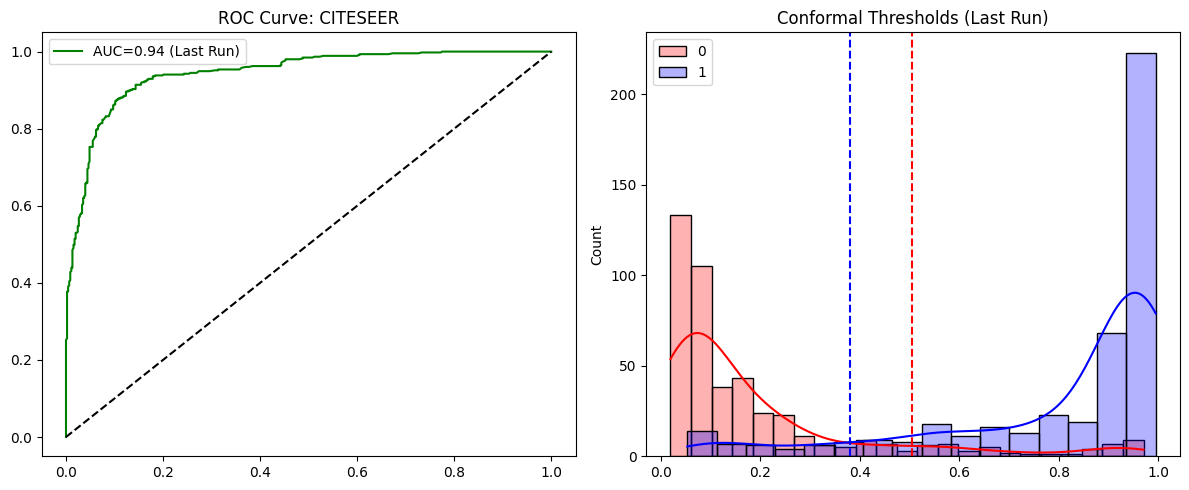

In [20]:
res_cite = run_pipeline("citeseer/adjacency.tsv", pos_path=None, name="citeseer")


Running Pipeline: OPENFLIGHTS (Averaging over 10 runs)
Computing SVD Embeddings (Rank 32)...
Run 1/10: AUC=0.9884 | Cov=0.9788 | Abs=0.0778
Run 2/10: AUC=0.9890 | Cov=0.9783 | Abs=0.0715
Run 3/10: AUC=0.9876 | Cov=0.9758 | Abs=0.0753
Run 4/10: AUC=0.9885 | Cov=0.9764 | Abs=0.0737
Run 5/10: AUC=0.9866 | Cov=0.9766 | Abs=0.0739
Run 6/10: AUC=0.9833 | Cov=0.9722 | Abs=0.0770
Run 7/10: AUC=0.9878 | Cov=0.9786 | Abs=0.0871
Run 8/10: AUC=0.9887 | Cov=0.9791 | Abs=0.0871
Run 9/10: AUC=0.9872 | Cov=0.9777 | Abs=0.0778
Run 10/10: AUC=0.9899 | Cov=0.9799 | Abs=0.0767

FINAL RESULTS (OPENFLIGHTS)
AUC: 0.9877 ± 0.0018
Base F1: 0.9509 ± 0.0017
Coverage: 0.9774 ± 0.0022
Abstention: 0.0778 ± 0.0053
Decided F1: 0.9755 ± 0.0024


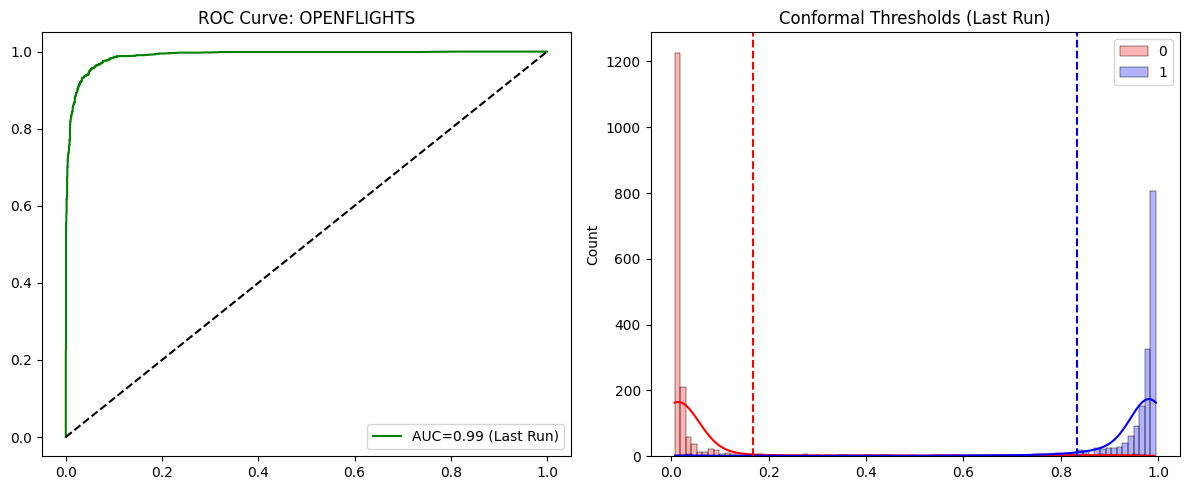

In [21]:
res_flight = run_pipeline("openflights/adjacency.tsv", pos_path="openflights/position.tsv", name="openflights")